In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gsk_data_cleaning
import gsk_feature_eng
import gsk_modeling
import gsk_error_analysis

import pycountry

from tqdm import tqdm

%matplotlib inline

In [2]:
np.random.seed(123)

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

pd.set_option('display.float_format', lambda x: "%3.f" % x)

-----

In [3]:
sku_sellout_data = pd.read_csv("../data/raw_data/export15.csv", dtype="str")
sku_sellin_data = pd.read_csv("../data/raw_data/export16.csv", dtype="str")

sku_sellin_data.drop(["Version.[Version Name]"], axis=1, inplace=True)
sku_sellout_data.drop(["Version.[Version Name]"], axis=1, inplace=True)

sku_sellin_data.rename(columns = {"Time.[Planning Month]": "month"
                                  , "Item.[L4]": "sub_brand"
                                  , "Sales Domain.[Channel]": "country"
                                  , "Sales Domain.[Ship To]": "customer" #banner
                                  , "Item.[Planning Item]": "sku"
                                  , "Actual": "actuals"}, inplace=True)

sku_sellout_data.rename(columns = {"Time.[Planning Month]": "month"
                                   , "Item.[L4]": "sub_brand"
                                  , "Sales Domain.[Channel]": "country"
                                  , "Sales Domain.[Ship To]": "customer"
                                  , "Item.[Planning Item]": "sku"
                                  , "Sell Out Actual": "actuals"}, inplace=True)

sku_data = pd.concat([sku_sellin_data, sku_sellout_data], axis=0, ignore_index=True)

sku_data["month"] = pd.to_datetime(sku_data["month"], format='%b-%y')
sku_data["actuals"] = sku_data["actuals"].astype("float64")

sku_data = sku_data[sku_data["actuals"]>0]

sku_data = sku_data[["sub_brand", "sku", "customer", "country", "month", "actuals"]]

sku_data.sample(5)

,sub_brand,sku,customer,country,month,actuals
26695,AF3505F246,60000000100782,8300000325,Germany,2017-04-01,2220
15179,AIFG02M05E,515773,8300000160,Germany,2017-06-01,12680
16665,AIFG02M05E,515774,8300000345,Germany,2016-12-01,200
17101,AIFG02M05C,514196,8300000284,Germany,2018-07-01,90
25101,AF3505F0GQ,60000000106898,8300000372,Germany,2017-12-01,36


In [4]:
sku_data["sub_brand"] = np.where((sku_data["sub_brand"]=="231") & (sku_data["country"]=="Malaysia")
                                 , "231M"
                                 , sku_data["sub_brand"])

In [5]:
sku_data["sub_brand"] = np.where((sku_data["sub_brand"]=="ADQ") & (sku_data["country"]=="Malaysia")
                                 , "ADQM"
                                 , sku_data["sub_brand"])

In [6]:
sku_data.nunique()

sub_brand      33
sku           324
customer      107
country         4
month          36
actuals      5259
dtype: int64

In [7]:
sku_data.isnull().sum()

sub_brand    0
sku          0
customer     0
country      0
month        0
actuals      0
dtype: int64

## Aggregating it on `sub-brand, month` level

In [8]:
sb_data = (sku_data
           .groupby(["sub_brand", "month"])
           .agg({"country": pd.unique
                 , "actuals": sum}).sort_values(by=["sub_brand", "month"], ascending=[True, True])
           .reset_index())

sb_data.sub_brand.value_counts()

246           36
AF3505F242    36
231           36
ADQM          36
233           36
231M          36
AF3505FADB    36
AF233340MR    36
0GZ           36
AE3           36
AH1703L06Y    36
AF3505D247    36
ADQ           36
AF3505F246    36
0H1           36
AF3505F245    36
242           36
AF3505E244    36
232           36
AF233330MP    36
AF3505F0LE    36
AH1703L070    35
AIFG02M05C    33
AIFG02M05E    33
AIFG02M05D    33
AF233340MS    27
AF233330MO    25
05Q           24
AF3505F0GQ    23
AF233340MQ    12
05R            8
AH1703L06Z     1
AF3505F243     1
Name: sub_brand, dtype: int64

#### Upsampling

In [9]:
print(sb_data.shape)
sb_data_ups = gsk_data_cleaning.perform_upsampling(sb_data, grouped_on=["sub_brand"], dependent_col="actuals", date_col="month")

sb_data_ups.drop(["sequence"], axis=1, inplace=True)

sb_data_ups.shape

(1011, 4)


(1020, 7)

In [10]:
sb_data_ups["country_code"]=np.where(sb_data_ups["country"]=="Poland", "PL", "abc")
sb_data_ups["country_code"]=np.where(sb_data_ups["country"]=="Germany", "DE", sb_data_ups["country_code"])
sb_data_ups["country_code"]=np.where(sb_data_ups["country"]=="Australia", "AU", sb_data_ups["country_code"])
sb_data_ups["country_code"]=np.where(sb_data_ups["country"]=="Malaysia", "MY", sb_data_ups["country_code"])

In [11]:
sb_data_ups.sample(10)

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code
804,AF3505F242,2017-01-01,Germany,1315774,0,2016-01-01,2018-12-01,DE
288,242,2016-01-01,Australia,131208,0,2016-01-01,2018-12-01,AU
1141,AIFG02M05D,2018-02-01,Germany,249555,0,2016-04-01,2018-12-01,DE
897,AF3505F245,2018-10-01,Germany,10099,0,2016-01-01,2018-12-01,DE
1047,AH1703L070,2016-04-01,Poland,2140,0,2016-01-01,2018-12-01,PL
1140,AIFG02M05D,2018-01-01,Germany,162362,0,2016-04-01,2018-12-01,DE
313,242,2018-02-01,Australia,480528,0,2016-01-01,2018-12-01,AU
416,ADQM,2017-09-01,Malaysia,125929,0,2016-01-01,2018-12-01,MY
212,231M,2018-09-01,Malaysia,253265,0,2016-01-01,2018-12-01,MY
344,246,2017-09-01,Australia,118032,0,2016-01-01,2018-12-01,AU


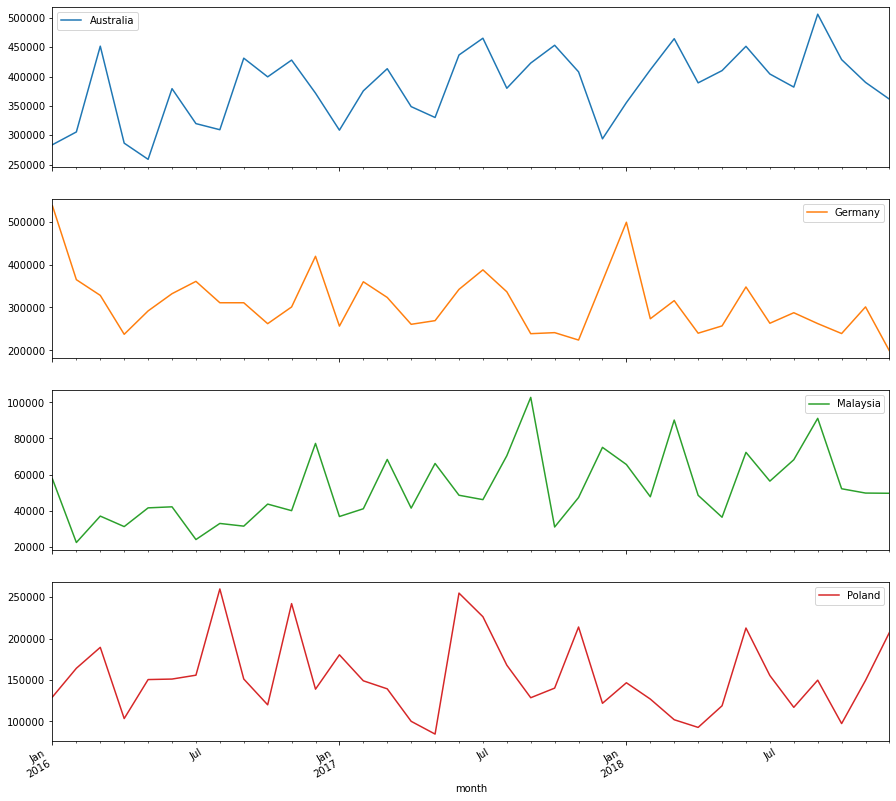

In [12]:
sb_data_ups[["month", "country", "actuals"]].pivot_table(index="month", columns="country", values="actuals").plot(subplots=True, sharex= True, figsize=(15, 15))
plt.show()

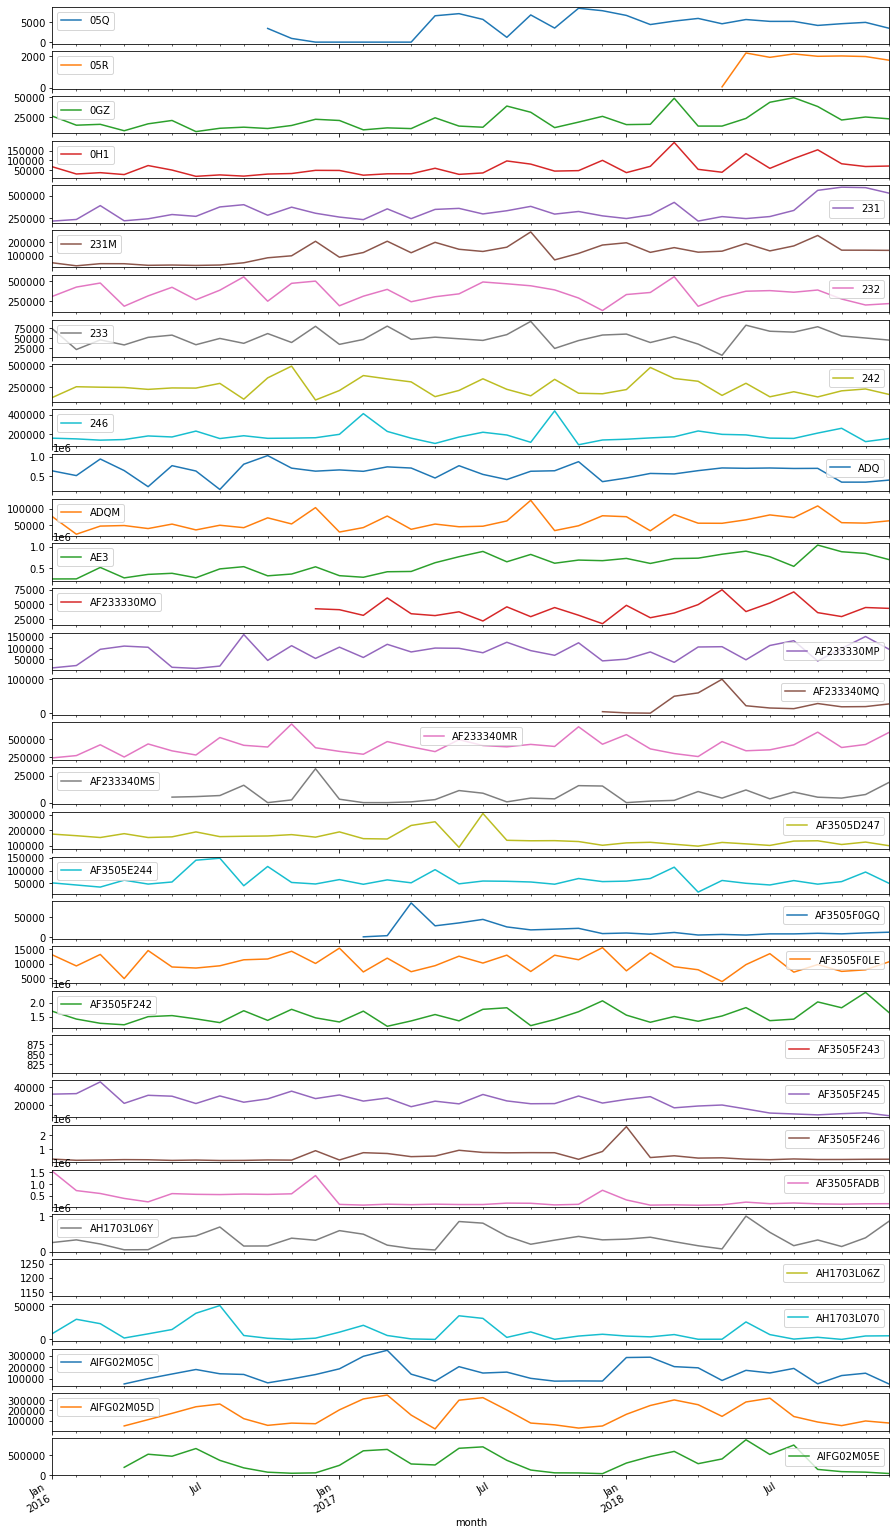

In [13]:
sb_data_ups[["month", "sub_brand", "actuals"]].pivot_table(index="month", columns="sub_brand", values="actuals").plot(subplots=True, sharex= True, figsize=(15, 30))
plt.show()

In [14]:
sb_data_ups = gsk_feature_eng.create_lag_variables(sb_data_ups, date_column="month"
                                                   , grouped_on = "sub_brand"
                                                   , shifting_var = "actuals"
                                                   , lag_vars_range = [3, 4, 5, 6, 7])

sb_data_ups = gsk_feature_eng.create_moving_avg(sb_data_ups, ma_vars = [1,2,3,4,5])
sb_data_ups.drop(["lag_3", "lag_4", "lag_5", "lag_6", "lag_7"], axis=1, inplace=True)
sb_data_ups

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5
9,05Q,2016-10-01,Malaysia,3412,0,2016-10-01,2018-12-01,MY,0,0,0,0,0
10,05Q,2016-11-01,Malaysia,922,0,2016-10-01,2018-12-01,MY,0,0,0,0,0
11,05Q,2016-12-01,Malaysia,2,0,2016-10-01,2018-12-01,MY,0,0,0,0,0
12,05Q,2017-01-01,Malaysia,1,0,2016-10-01,2018-12-01,MY,3412,1706,1137,853,682
13,05Q,2017-02-01,Malaysia,0,1,2016-10-01,2018-12-01,MY,922,2167,1445,1084,867
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,AIFG02M05E,2018-08-01,Germany,751419,0,2016-04-01,2018-12-01,DE,402117,342716,425798,435358,408081
1184,AIFG02M05E,2018-09-01,Germany,139306,0,2016-04-01,2018-12-01,DE,884207,643162,523213,540400,525127
1185,AIFG02M05E,2018-10-01,Germany,83021,0,2016-04-01,2018-12-01,DE,514505,699356,600276,521036,535221
1186,AIFG02M05E,2018-11-01,Germany,70246,0,2016-04-01,2018-12-01,DE,751419,632962,716710,638062,567112


## Function related to Univariate Modeling

In [15]:
def start_univariate_modeling(dataset, forecast_month, date_col, lag_of=2, grouped_on="sequence", dependent_var="actual"):
    
    from functools import reduce

    results=pd.DataFrame()

    print("Running Arima...")
    arima_results = gsk_modeling.perform_autoarima(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
                                                   , grouped_on=grouped_on, dependent_var=dependent_var)
    print("Running ETS...")
    ets_results = gsk_modeling.perform_ets(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
                                           , grouped_on=grouped_on, dependent_var=dependent_var).drop([dependent_var], axis=1)
    print("Running Seasonal Naive...")
    sktime_naive_results = gsk_modeling.perform_sktime_naive(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
                                                             , grouped_on=grouped_on, dependent_var=dependent_var).drop([dependent_var], axis=1)
    print("Running Reduction...")
    red_results = gsk_modeling.perform_sktime_reduction(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
                                                        , grouped_on=grouped_on, dependent_var=dependent_var).drop([dependent_var], axis=1)
    print("Running Prophet...")
    prophet_results = gsk_modeling.create_prophet_forecast(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
                                                           , grouped_on=grouped_on, dependent_var=dependent_var)
    
    dataframes = [arima_results
                  , ets_results
                  , sktime_naive_results
                  , red_results
                  , prophet_results]
    
    results = reduce(lambda left, right: pd.merge(left, right, on = [grouped_on, date_col], how='inner'), dataframes)
    
    return results

-----
# Forecasting for October 2018

> - Training Month : Till April 2018    
> - Validation Month: July 2018    
> - Prediction Month: October 2018

In [16]:
training_validation = sb_data_ups[sb_data_ups["month"]<="2018-07-01"]
training_prediction = sb_data_ups[sb_data_ups["month"]<="2018-10-01"]

training_validation.shape, training_prediction.shape, training_prediction.sub_brand.nunique(), training_validation.sub_brand.nunique()

((863, 13), (956, 13), 31, 31)

### Modeling on training data

In [17]:
july_univ_results = start_univariate_modeling(dataset = training_validation
                                              , forecast_month = "2018-07-01"
                                              , date_col = "month"
                                              , lag_of=2
                                              , grouped_on="sub_brand"
                                              , dependent_var="actuals")
july_univ_results.shape

Running Arima...


 23%|███████████████████████████████████████▎                                                                                                                                      | 7/31 [00:00<00:00, 52.44it/s]

Running ETS...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 330.96it/s]


Running Seasonal Naive...
Running Reduction...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 121.63it/s]


Running Prophet...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:10<00:00,  2.34s/it]


(30, 13)

In [18]:
july_univ_results.head()

,sub_brand,month,actuals,arima_forecast,arima_status,ets_forecast,ets_status,sn_forecast,sn_status,red_forecast,red_status,prophet_status,prophet_forecast
0,05Q,2018-07-01,5173,8202,0,8203,0,8447,0,5245,0,0,9000
1,0GZ,2018-07-01,43503,17640,0,26347,0,18416,0,25706,0,0,11338
2,0H1,2018-07-01,59650,89573,0,122917,0,48208,0,54691,0,0,47176
3,231,2018-07-01,270540,305297,0,288004,0,326514,0,299304,0,0,300323
4,231M,2018-07-01,135995,161836,0,126574,0,117061,0,280294,0,0,191464


In [19]:
training_validation.head()

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5
9,05Q,2016-10-01,Malaysia,3412,0,2016-10-01,2018-12-01,MY,0,0,0,0,0
10,05Q,2016-11-01,Malaysia,922,0,2016-10-01,2018-12-01,MY,0,0,0,0,0
11,05Q,2016-12-01,Malaysia,2,0,2016-10-01,2018-12-01,MY,0,0,0,0,0
12,05Q,2017-01-01,Malaysia,1,0,2016-10-01,2018-12-01,MY,3412,1706,1137,853,682
13,05Q,2017-02-01,Malaysia,0,1,2016-10-01,2018-12-01,MY,922,2167,1445,1084,867


In [20]:
print(july_univ_results.shape)
july_univ_af = pd.merge(left = july_univ_results, right = training_validation, on = ["sub_brand", "month", "actuals"], how="inner")
july_univ_af.shape

(30, 13)


(30, 23)

### Checking the results on validation data

In [21]:
# validation_results_mature = validation_results[validation_results["mature"]==1]
list_of_forecast = ['arima_forecast', 'ets_forecast', 'sn_forecast', 'red_forecast', "prophet_forecast", "naive", "ma_2", "ma_3", "ma_4", "ma_5"]
error_list=[]

for sequence in tqdm(july_univ_af.sub_brand.unique()):
    temp_df = july_univ_af[july_univ_af["sub_brand"]==sequence]
    for forecast in list_of_forecast:
        err = gsk_error_analysis.calc_accuracy(temp_df, "actuals", forecast)
        error_list.append([sequence, forecast, err])

error_df = pd.DataFrame(error_list, columns=["sub_brand", "Algorithm", "Accuracy"])
error_df = error_df.pivot_table(values="Accuracy", index="sub_brand", columns="Algorithm")
error_df["best_fit_algo"] = error_df.idxmax(axis=1)
error_df["best_fit"] = error_df.max(axis=1)
error_df.reset_index(inplace=True)
error_df.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.37it/s]


(30, 13)

In [22]:
forecast_actuals_list=[]
for sku in error_df.sub_brand.unique():
    tmp_df = error_df[error_df["sub_brand"]==sku]
    algo_name = tmp_df["best_fit_algo"].values[0]
    actuals = july_univ_af[july_univ_af["sub_brand"]==sku]["actuals"].values[0]
    forecast = july_univ_af[july_univ_af["sub_brand"]==sku][algo_name].values[0]
    forecast_actuals_list.append([sku, algo_name, actuals, forecast])
    
forecast_actuals_df = pd.DataFrame(forecast_actuals_list, columns=["sub_brand", "Algorithm", "Actuals", "Forecast"])

In [23]:
gsk_error_analysis.calc_accuracy(forecast_actuals_df, "Actuals", "Forecast")

92.84834992490016

In [24]:
forecast_actuals_df.Algorithm.value_counts()

red_forecast        6
ma_2                5
naive               5
ma_3                4
arima_forecast      3
ma_4                2
sn_forecast         2
ets_forecast        2
prophet_forecast    1
Name: Algorithm, dtype: int64

### Using the same algos for same `sub_model`

In [25]:
print(training_prediction.shape, forecast_actuals_df.shape)
training_prediction = pd.merge(left = training_prediction
                               , right = forecast_actuals_df[["sub_brand", "Algorithm"]]
                               , on = "sub_brand"
                               , how = "left")

print(training_prediction.shape)

training_prediction.sample(5)

(956, 13) (30, 4)
(956, 14)


,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm
892,AIFG02M05C,2018-09-01,Germany,54561,0,2016-04-01,2018-12-01,DE,171699,127690,149667,163280,187847,arima_forecast
871,AIFG02M05C,2016-12-01,Germany,135181,0,2016-04-01,2018-12-01,DE,136008,138986,152356,149230,139351,arima_forecast
107,231,2016-09-01,Australia,401634,0,2016-01-01,2018-12-01,AU,292812,269226,254040,288408,278360,ets_forecast
901,AIFG02M05D,2016-11-01,Germany,74922,0,2016-04-01,2018-12-01,DE,264207,250628,224300,195514,165802,prophet_forecast
35,0GZ,2016-05-01,Malaysia,16269,0,2016-01-01,2018-12-01,MY,14529,20232,13488,10116,8093,ma_2


In [26]:
training_prediction.sub_brand.nunique()

31

In [27]:
training_prediction.groupby("sub_brand").agg({"Algorithm": pd.unique}).Algorithm.value_counts(dropna = False)

red_forecast        6
ma_2                5
naive               5
ma_3                4
arima_forecast      3
ma_4                2
sn_forecast         2
ets_forecast        2
prophet_forecast    1
NaN                 1
Name: Algorithm, dtype: int64

In [28]:
training_prediction[training_prediction["Algorithm"].isnull()].sub_brand.unique()

array(['05R'], dtype=object)

In [29]:
values={"Algorithm": "ma_2"}
training_prediction.fillna(values, inplace=True)

### Modeling on training data for Test data

In [30]:
training_prediction[training_prediction["month"]=="2018-10-01"].Algorithm.value_counts()

red_forecast        6
ma_2                6
naive               5
ma_3                4
arima_forecast      3
ma_4                2
sn_forecast         2
ets_forecast        2
prophet_forecast    1
Name: Algorithm, dtype: int64

In [31]:
training_prediction.loc[(training_prediction["sub_brand"]=="AIFG02M05E"), ["Algorithm"]] = "arima_forecast"
training_prediction.loc[(training_prediction["sub_brand"]=="AF3505F242"), ["Algorithm"]] = "arima_forecast"
training_prediction.loc[(training_prediction["sub_brand"]=="ADQ"), ["Algorithm"]] = "arima_forecast"
training_prediction.loc[(training_prediction["sub_brand"]=="231"), ["Algorithm"]] = "arima_forecast"
training_prediction[training_prediction["month"]=="2018-10-01"].Algorithm.value_counts()

arima_forecast      7
ma_2                6
red_forecast        5
naive               4
ma_3                3
ma_4                2
sn_forecast         2
prophet_forecast    1
ets_forecast        1
Name: Algorithm, dtype: int64

In [32]:
training_prediction.sample(5)

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm
58,0GZ,2018-04-01,Malaysia,13412,0,2016-01-01,2018-12-01,MY,15275,20490,19799,17714,20349,ma_2
230,233,2018-06-01,Malaysia,82213,0,2016-01-01,2018-12-01,MY,53542,46164,50760,52464,50710,red_forecast
836,AH1703L070,2016-08-01,Poland,50440,0,2016-01-01,2018-12-01,PL,8336,5238,11312,15989,14551,arima_forecast
567,AF3505D247,2018-08-01,Germany,129475,0,2016-01-01,2018-12-01,DE,120699,108696,108789,112004,113177,ma_2
550,AF3505D247,2017-03-01,Germany,143051,0,2016-01-01,2018-12-01,DE,154973,163142,162958,162410,161594,ma_2


In [33]:
forecast_df = pd.DataFrame()

### Checking the results on test data

In [35]:
print("ma_5", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="ma_5")], "actuals", "Forecast"))
print("ma_4", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="ma_4")], "actuals", "Forecast"))
print("ma_3", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="ma_3")], "actuals", "Forecast"))
print("ma_2", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="ma_2")], "actuals", "Forecast"))
print("naive", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="naive")], "actuals", "Forecast"))
print("seasonal naive", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="sn_forecast")], "actuals", "Forecast"))
print("ets", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="ets_forecast")], "actuals", "Forecast"))
print("Arima", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="arima_forecast")], "actuals", "Forecast"))
print("Reduction", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="red_forecast")], "actuals", "Forecast"))
print("Prophet", gsk_error_analysis.calc_accuracy(forecast_df[(forecast_df["month"]=="2018-10-01") & (forecast_df["Algorithm"]=="prophet_forecast")], "actuals", "Forecast"))

ma_5 100
ma_4 90.7097745752816
ma_3 90.48995222354273
ma_2 72.12061471723176
naive 83.84205063355907
seasonal naive 90.71906258537447
ets 86.88082247420067
Arima 61.357814377369984
Reduction 51.79234424004566
Prophet -56.82094931827359


In [36]:
gsk_error_analysis.calc_accuracy(forecast_df[forecast_df["month"]=="2018-10-01"], "actuals", "Forecast")

69.36862688244646

In [37]:
forecast_df["abs_error"] = abs(forecast_df["actuals"] - forecast_df["Forecast"])
kp = forecast_df[forecast_df["month"]=="2018-10-01"].sort_values(by="abs_error", ascending=False)
kp

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm,Forecast,abs_error
890,AF3505F242,2018-10-01,Germany,1817918,0,2016-01-01,2018-12-01,DE,1362220,1592596,1570799,1513337,1512362,arima_forecast,1498936,318982
168,231,2018-10-01,Australia,595372,0,2016-01-01,2018-12-01,AU,270540,259239,262774,252210,287240,arima_forecast,301182,294190
426,ADQ,2018-10-01,Australia,346176,0,2016-01-01,2018-12-01,AU,706968,703116,704784,688428,661824,arima_forecast,625010,278834
1225,AIFG02M05E,2018-10-01,Germany,83021,0,2016-04-01,2018-12-01,DE,514505,699356,600276,521036,535221,arima_forecast,298912,215891
1062,AH1703L06Y,2018-10-01,Poland,143989,0,2016-01-01,2018-12-01,PL,544521,774330,541427,447450,414143,red_forecast,323793,179804
512,AE3,2018-10-01,Australia,884760,0,2016-01-01,2018-12-01,AU,767304,832722,830676,806517,789938,naive,767304,117456
254,232,2018-10-01,Australia,278106,0,2016-01-01,2018-12-01,AU,381936,378210,352940,311823,360360,ma_2,378210,100104
1185,AIFG02M05D,2018-10-01,Germany,50126,0,2016-04-01,2018-12-01,DE,322115,303256,249488,251425,262078,prophet_forecast,128734,78608
383,246,2018-10-01,Australia,260616,0,2016-01-01,2018-12-01,AU,160428,176784,184120,196395,191909,red_forecast,199104,61512
650,AF233340MR,2018-10-01,Poland,386541,0,2016-01-01,2018-12-01,PL,353516,346814,387933,355547,344582,ets_forecast,335830,50711


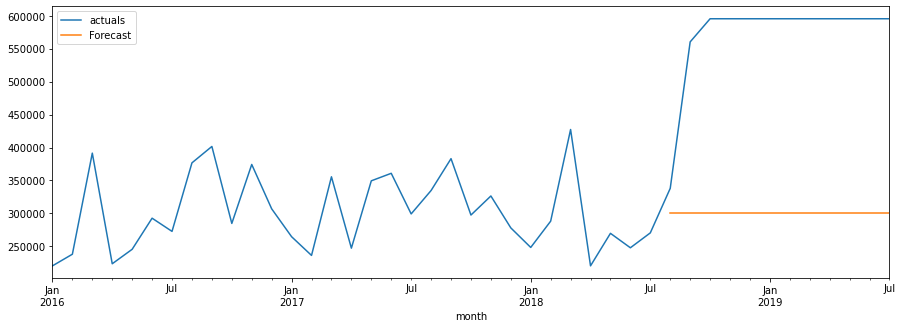

In [38]:
forecast_df[forecast_df["sub_brand"]=="231"][["month", "actuals", "Forecast"]].plot(x = "month", figsize=(15, 5))
plt.show()

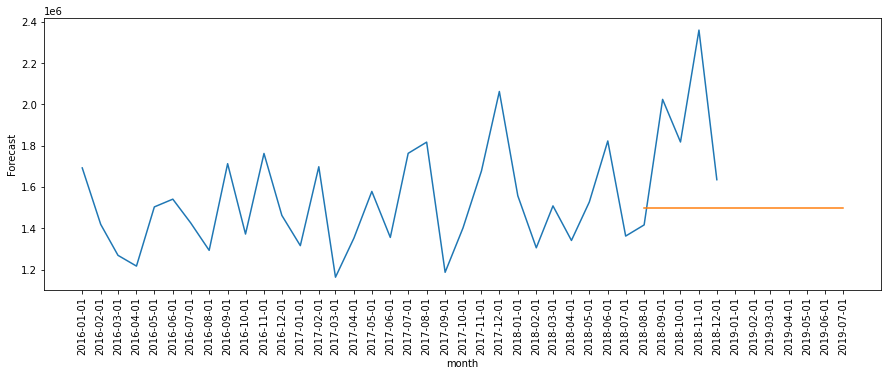

In [121]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.lineplot(x="month"
                  , y="actuals"
                  , markers=True
                  , dashes=False
                  , data=sb_data_ups[sb_data_ups["sub_brand"]=="AF3505F242"])

sns.lineplot(x="month"
                  , y="Forecast"
                  , markers=True
                  , dashes=False
                  , data=forecast_df[forecast_df["sub_brand"]=="AF3505F242"])
plt.xticks(forecast_df["month"].unique(), rotation='vertical')
plt.show()

In [40]:
error_df[error_df["sub_brand"]=="231"]

Algorithm,sub_brand,arima_forecast,ets_forecast,ma_2,ma_3,ma_4,ma_5,naive,prophet_forecast,red_forecast,sn_forecast,best_fit_algo,best_fit
3,231,87,94,80,85,91,92,82,89,89,79,ets_forecast,94


In [41]:
# forecast_df[forecast_df["month"]=="2018-10-01"]

----
# Forecasting for November 2018

> - Training Month : Till May 2018    
> - Validation Month: August 2018    
> - Prediction Month: November 2018

In [42]:
training_validation = sb_data_ups[sb_data_ups["month"]<="2018-08-01"]
training_prediction = sb_data_ups[sb_data_ups["month"]<="2018-11-01"]

training_validation.shape, training_prediction.shape, training_prediction.sub_brand.nunique(), training_validation.sub_brand.nunique()

((894, 13), (987, 13), 31, 31)

### Modeling on training data

In [43]:
aug_univ_results = start_univariate_modeling(dataset = training_validation
                                              , forecast_month = "2018-08-01"
                                              , date_col = "month"
                                              , lag_of=2
                                              , grouped_on="sub_brand"
                                              , dependent_var="actuals")
aug_univ_results.shape

  0%|                                                                                                                                                                                      | 0/31 [00:00<?, ?it/s]

Running Arima...


 19%|█████████████████████████████████▋                                                                                                                                            | 6/31 [00:00<00:00, 59.90it/s]

Running ETS...


  0%|                                                                                                                                                                                      | 0/31 [00:00<?, ?it/s]

Running Seasonal Naive...
Running Reduction...


  0%|                                                                                                                                                                                      | 0/31 [00:00<?, ?it/s]

Running Prophet...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:58<00:00,  1.88s/it]


(31, 13)

In [44]:
print(aug_univ_results.shape)
aug_univ_af = pd.merge(left = aug_univ_results, right = training_validation, on = ["sub_brand", "month", "actuals"], how="inner")
aug_univ_af.shape

(31, 13)


(31, 23)

### Checking the results on validation data - November 2018

In [45]:
# validation_results_mature = validation_results[validation_results["mature"]==1]
list_of_forecast = ['arima_forecast', 'ets_forecast', 'sn_forecast', 'red_forecast', "prophet_forecast", "naive", "ma_2", "ma_3", "ma_4", "ma_5"]
error_list=[]

for sequence in tqdm(aug_univ_af.sub_brand.unique()):
    temp_df = aug_univ_af[aug_univ_af["sub_brand"]==sequence]
    for forecast in list_of_forecast:
        err = gsk_error_analysis.calc_accuracy(temp_df, "actuals", forecast)
        error_list.append([sequence, forecast, err])

error_df = pd.DataFrame(error_list, columns=["sub_brand", "Algorithm", "Accuracy"])
error_df = error_df.pivot_table(values="Accuracy", index="sub_brand", columns="Algorithm")
error_df["best_fit_algo"] = error_df.idxmax(axis=1)
error_df["best_fit"] = error_df.max(axis=1)
error_df.reset_index(inplace=True)
error_df.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 84.27it/s]


(31, 13)

In [46]:
forecast_actuals_list=[]
for sku in error_df.sub_brand.unique():
    tmp_df = error_df[error_df["sub_brand"]==sku]
    algo_name = tmp_df["best_fit_algo"].values[0]
    actuals = aug_univ_af[aug_univ_af["sub_brand"]==sku]["actuals"].values[0]
    forecast = aug_univ_af[aug_univ_af["sub_brand"]==sku][algo_name].values[0]
    forecast_actuals_list.append([sku, algo_name, actuals, forecast])
    
forecast_actuals_df = pd.DataFrame(forecast_actuals_list, columns=["sub_brand", "Algorithm", "Actuals", "Forecast"])

In [47]:
gsk_error_analysis.calc_accuracy(forecast_actuals_df, "Actuals", "Forecast")

89.07822897107984

In [48]:
forecast_actuals_df.Algorithm.value_counts()

naive               8
sn_forecast         4
prophet_forecast    4
ma_3                3
ma_2                3
ma_4                2
arima_forecast      2
ma_5                2
red_forecast        2
ets_forecast        1
Name: Algorithm, dtype: int64

## Using the same-algos for same sub_brands - November 2018

In [49]:
print(training_prediction.shape, forecast_actuals_df.shape)
training_prediction = pd.merge(left = training_prediction
                               , right = forecast_actuals_df[["sub_brand", "Algorithm"]]
                               , on = "sub_brand"
                               , how = "left")

print(training_prediction.shape)

training_prediction.sample(5)

(987, 13) (31, 4)
(987, 14)


,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm
245,242,2016-03-01,Australia,250620,0,2016-01-01,2018-12-01,AU,0,0,0,0,0,prophet_forecast
145,231M,2016-08-01,Malaysia,28805,0,2016-01-01,2018-12-01,MY,26585,32623,34776,31798,34580,sn_forecast
786,AF3505FADB,2016-01-01,Germany,1542368,0,2016-01-01,2018-12-01,DE,0,0,0,0,0,ma_5
592,AF3505E244,2016-04-01,Germany,62147,0,2016-01-01,2018-12-01,DE,51441,25720,17147,12860,10288,naive
905,AIFG02M05C,2017-06-01,Germany,203763,0,2016-04-01,2018-12-01,DE,346269,320086,275039,240074,211438,ma_4


In [50]:
training_prediction.sub_brand.nunique()

31

In [51]:
values={"Algorithm": "ma_2"}
training_prediction.fillna(values, inplace=True)

### Modeling on training data for `november 2018` test data

In [52]:
training_prediction[training_prediction["month"]=="2018-11-01"].Algorithm.value_counts()

naive               8
sn_forecast         4
prophet_forecast    4
ma_3                3
ma_2                3
ma_4                2
arima_forecast      2
ma_5                2
red_forecast        2
ets_forecast        1
Name: Algorithm, dtype: int64

In [53]:
training_prediction.loc[(training_prediction["sub_brand"]=="AIFG02M05E"), ["Algorithm"]] = "arima_forecast"
training_prediction.loc[(training_prediction["sub_brand"]=="246"), ["Algorithm"]] = "arima_forecast"
training_prediction.loc[(training_prediction["sub_brand"]=="242"), ["Algorithm"]] = "arima_forecast"
training_prediction[training_prediction["month"]=="2018-11-01"].Algorithm.value_counts()

naive               8
arima_forecast      5
sn_forecast         4
prophet_forecast    3
ma_3                3
ma_2                3
ma_4                2
ma_5                2
red_forecast        1
Name: Algorithm, dtype: int64

In [54]:
training_prediction.sample(5)

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm
977,AIFG02M05E,2018-02-01,Germany,464036,0,2016-04-01,2018-12-01,DE,50670,51773,75665,148746,260179,arima_forecast
260,242,2017-06-01,Australia,212779,0,2016-01-01,2018-12-01,AU,347448,366852,315192,261705,308650,arima_forecast
2,05Q,2016-12-01,Malaysia,2,0,2016-10-01,2018-12-01,MY,0,0,0,0,0,ma_2
374,ADQM,2018-03-01,Malaysia,82076,0,2016-01-01,2018-12-01,MY,78412,63031,52947,71193,69449,prophet_forecast
583,AF3505D247,2018-06-01,Germany,111478,0,2016-01-01,2018-12-01,DE,108974,115312,116164,112710,115470,naive


In [55]:
nov_forecast_df = pd.DataFrame()

In [56]:
for sku in tqdm(training_prediction.sub_brand.unique()):
    sku_series = training_prediction[training_prediction["sub_brand"]==sku]
    if sku_series["Algorithm"].unique() == "ets_forecast":
        sku_series = gsk_modeling.single_run_ets(sku_series, lag_of=2, forecast_month="2018-11-01", forecast_period=12, month_var="month", dependent_var="actuals")
    elif sku_series["Algorithm"].unique() == "arima_forecast":
        sku_series = gsk_modeling.single_run_arima(sku_series, lag_of=2, forecast_month="2018-11-01", forecast_period=12, month_var = "month", dependent_var="actuals")
    elif sku_series["Algorithm"].unique() == "red_forecast":
        sku_series = gsk_modeling.single_run_reduction(sku_series, lag_of=2, forecast_month="2018-11-01", forecast_period=12, month_var="month", dependent_var="actuals")
    elif sku_series["Algorithm"].unique() == "sn_forecast":
        sku_series = gsk_modeling.single_run_sn(sku_series, lag_of=2, forecast_month="2018-11-01", forecast_period=12, month_var="month", dependent_var="actuals")
    elif sku_series["Algorithm"].unique() == "prophet_forecast":
        sku_series = gsk_modeling.single_run_prophet(sku_series, lag_of=2, forecast_month="2018-11-01", forecast_period=12, month_var="month", dependent_var="actuals")
    else:
        sku_series = gsk_modeling.single_run_generic(sku_series, lag_of=2, grouped_on="sub_brand", forecast_month="2018-11-01", forecast_period=12, month_var="month"
                                                     , dependent_var="actuals")
    nov_forecast_df = pd.concat([nov_forecast_df, sku_series], axis=0, ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.65it/s]


In [57]:
nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["sub_brand"]=="AF3505F246")]

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm,Forecast
1001,AF3505F246,2018-11-01,Germany,242043,0,2016-01-01,2018-12-01,DE,266544,239097,242146,268974,281051,ma_2,239097


# Checking the results on November test data

In [58]:
print("ma_5", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="ma_5")], "actuals", "Forecast"))
print("ma_4", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="ma_4")], "actuals", "Forecast"))
print("ma_3", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="ma_3")], "actuals", "Forecast"))
print("ma_2", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="ma_2")], "actuals", "Forecast"))
print("naive", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="naive")], "actuals", "Forecast"))
print("seasonal naive", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="sn_forecast")], "actuals", "Forecast"))
print("ets", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="ets_forecast")], "actuals", "Forecast"))
print("Arima", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="arima_forecast")], "actuals", "Forecast"))
print("Reduction", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="red_forecast")], "actuals", "Forecast"))
print("Prophet", gsk_error_analysis.calc_accuracy(nov_forecast_df[(nov_forecast_df["month"]=="2018-11-01") & (nov_forecast_df["Algorithm"]=="prophet_forecast")], "actuals", "Forecast"))

ma_5 97.04490743569377
ma_4 66.92075590918049
ma_3 50.5577987986287
ma_2 98.40030653750172
naive 43.91467771835841
seasonal naive 83.55566634216669
ets 100
Arima 19.278454751989045
Reduction 83.08954121849494
Prophet 63.43173938952095


In [59]:
gsk_error_analysis.calc_accuracy(nov_forecast_df[nov_forecast_df["month"]=="2018-11-01"], "actuals", "Forecast")

62.8394061520928

In [60]:
nov_forecast_df["abs_error"] = abs(nov_forecast_df["actuals"] - nov_forecast_df["Forecast"])
kp = nov_forecast_df[nov_forecast_df["month"]=="2018-11-01"].sort_values(by="abs_error", ascending=False)

In [61]:
kp[kp["Algorithm"]=="arima_forecast"]

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm,Forecast,abs_error
1256,AIFG02M05E,2018-11-01,Germany,70246,0,2016-04-01,2018-12-01,DE,751419,632962,716710,638062,567112,arima_forecast,345727,275481
261,232,2018-11-01,Australia,204048,0,2016-01-01,2018-12-01,AU,362112,372024,372844,355233,321881,arima_forecast,357455,153407
393,246,2018-11-01,Australia,124956,0,2016-01-01,2018-12-01,AU,157680,159054,170416,177510,188652,arima_forecast,184940,59984
349,242,2018-11-01,Australia,230064,0,2016-01-01,2018-12-01,AU,197664,168210,210920,196938,221527,arima_forecast,254730,24666
623,AF233340MQ,2018-11-01,Poland,19488,0,2017-12-01,2018-12-01,PL,13332,14324,16892,37844,42312,arima_forecast,29673,10185


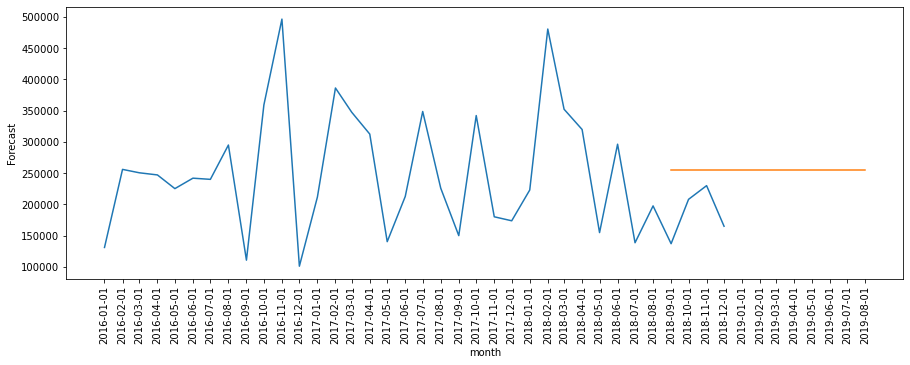

In [62]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.lineplot(x="month"
                  , y="actuals"
                  , markers=True
                  , dashes=False
                  , data=sb_data_ups[sb_data_ups["sub_brand"]=="242"])

sns.lineplot(x="month"
                  , y="Forecast"
                  , markers=True
                  , dashes=False
                  , data=nov_forecast_df[nov_forecast_df["sub_brand"]=="242"])
plt.xticks(nov_forecast_df["month"].unique(), rotation='vertical')
plt.show()

# Forecasting for November 2018
> - Training Month : Till May 2018
> - Validation Month: August 2018
> - Prediction Month: November 2018

In [63]:
training_validation = sb_data_ups[sb_data_ups["month"]<="2018-09-01"]
training_prediction = sb_data_ups[sb_data_ups["month"]<="2018-12-01"]

training_validation.shape, training_prediction.shape, training_prediction.sub_brand.nunique(), training_validation.sub_brand.nunique()

((925, 13), (1020, 13), 33, 31)

## Modeling on training data

In [64]:
sep_univ_results = start_univariate_modeling(dataset = training_validation
                                             , forecast_month = "2018-09-01"
                                             , date_col = "month"
                                             , lag_of=2
                                             , grouped_on="sub_brand"
                                             , dependent_var="actuals")
sep_univ_results.shape

  0%|                                                                                                                                                                                      | 0/31 [00:00<?, ?it/s]

Running Arima...


 19%|█████████████████████████████████▋                                                                                                                                            | 6/31 [00:00<00:00, 53.44it/s]

Running ETS...


  0%|                                                                                                                                                                                      | 0/31 [00:00<?, ?it/s]

Running Seasonal Naive...
Running Reduction...


  0%|                                                                                                                                                                                      | 0/31 [00:00<?, ?it/s]

Running Prophet...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:58<00:00,  1.87s/it]


(31, 13)

In [65]:
print(sep_univ_results.shape)
sep_univ_af = pd.merge(left = sep_univ_results, right = training_validation, on = ["sub_brand", "month", "actuals"], how="inner")
sep_univ_af.shape

(31, 13)


(31, 23)

## Checking the results on validation data - December 2018

In [66]:
# validation_results_mature = validation_results[validation_results["mature"]==1]
list_of_forecast = ['arima_forecast', 'ets_forecast', 'sn_forecast', 'red_forecast', "prophet_forecast", "naive", "ma_2", "ma_3", "ma_4", "ma_5"]
error_list=[]

for sequence in tqdm(sep_univ_af.sub_brand.unique()):
    temp_df = sep_univ_af[sep_univ_af["sub_brand"]==sequence]
    for forecast in list_of_forecast:
        err = gsk_error_analysis.calc_accuracy(temp_df, "actuals", forecast)
        error_list.append([sequence, forecast, err])

error_df = pd.DataFrame(error_list, columns=["sub_brand", "Algorithm", "Accuracy"])
error_df = error_df.pivot_table(values="Accuracy", index="sub_brand", columns="Algorithm")
error_df["best_fit_algo"] = error_df.idxmax(axis=1)
error_df["best_fit"] = error_df.max(axis=1)
error_df.reset_index(inplace=True)
error_df.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 88.95it/s]


(31, 13)

In [68]:
forecast_actuals_list=[]
for sku in error_df.sub_brand.unique():
    tmp_df = error_df[error_df["sub_brand"]==sku]
    algo_name = tmp_df["best_fit_algo"].values[0]
    actuals = sep_univ_af[sep_univ_af["sub_brand"]==sku]["actuals"].values[0]
    forecast = sep_univ_af[sep_univ_af["sub_brand"]==sku][algo_name].values[0]
    forecast_actuals_list.append([sku, algo_name, actuals, forecast])
    
forecast_actuals_df = pd.DataFrame(forecast_actuals_list, columns=["sub_brand", "Algorithm", "Actuals", "Forecast"])

In [69]:
gsk_error_analysis.calc_accuracy(forecast_actuals_df, "Actuals", "Forecast")

90.99632900232533

In [70]:
forecast_actuals_df.Algorithm.value_counts()

naive               10
sn_forecast          5
red_forecast         5
prophet_forecast     4
arima_forecast       2
ma_3                 2
ets_forecast         2
ma_2                 1
Name: Algorithm, dtype: int64

### Using the same-algos for same sub_brands - December 2018

In [71]:
print(training_prediction.shape, forecast_actuals_df.shape)
training_prediction = pd.merge(left = training_prediction
                               , right = forecast_actuals_df[["sub_brand", "Algorithm"]]
                               , on = "sub_brand"
                               , how = "left")

print(training_prediction.shape)

(1020, 13) (31, 4)
(1020, 14)


In [72]:
training_prediction.sample(5)

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm
192,232,2017-02-01,Australia,312960,0,2016-01-01,2018-12-01,AU,472044,361476,425102,415627,386294,ets_forecast
58,0GZ,2017-12-01,Malaysia,25706,0,2016-01-01,2018-12-01,MY,30891,34809,27192,23746,23778,prophet_forecast
875,AH1703L06Y,2018-04-01,Poland,165521,0,2016-01-01,2018-12-01,PL,352386,342236,371372,359477,329202,arima_forecast
320,246,2018-10-01,Australia,260616,0,2016-01-01,2018-12-01,AU,160428,176784,184120,196395,191909,ma_3
266,242,2017-04-01,Australia,312528,0,2016-01-01,2018-12-01,AU,211872,156558,269848,292179,255922,red_forecast


In [73]:
training_prediction.sub_brand.nunique()

33

In [74]:
values={"Algorithm": "ma_2"}
training_prediction.fillna(values, inplace=True)

### Modeling on training data for December 2018 test data

In [100]:
training_prediction[training_prediction["month"]=="2018-12-01"].Algorithm.value_counts()

naive               10
sn_forecast          5
prophet_forecast     4
red_forecast         4
arima_forecast       3
ma_2                 3
ma_3                 2
ets_forecast         2
Name: Algorithm, dtype: int64

In [101]:
# training_prediction.loc[(training_prediction["sub_brand"]=="AIFG02M05E"), ["Algorithm"]] = "arima_forecast"
# training_prediction.loc[(training_prediction["sub_brand"]=="246"), ["Algorithm"]] = "arima_forecast"
training_prediction.loc[(training_prediction["sub_brand"]=="231"), ["Algorithm"]] = "arima_forecast"
training_prediction[training_prediction["month"]=="2018-12-01"].Algorithm.value_counts()

naive               10
sn_forecast          5
prophet_forecast     4
red_forecast         4
arima_forecast       3
ma_2                 3
ma_3                 2
ets_forecast         2
Name: Algorithm, dtype: int64

In [102]:
dec_forecast_df = pd.DataFrame()

for sku in tqdm(training_prediction.sub_brand.unique()):
    sku_series = training_prediction[training_prediction["sub_brand"]==sku]
    if sku_series["Algorithm"].unique() == "ets_forecast":
        sku_series = gsk_modeling.single_run_ets(sku_series, lag_of=2, forecast_month="2018-12-01", forecast_period=12, month_var="month", dependent_var="actuals")
    elif sku_series["Algorithm"].unique() == "arima_forecast":
        sku_series = gsk_modeling.single_run_arima(sku_series, lag_of=2, forecast_month="2018-12-01", forecast_period=12, month_var = "month", dependent_var="actuals")
    elif sku_series["Algorithm"].unique() == "red_forecast":
        sku_series = gsk_modeling.single_run_reduction(sku_series, lag_of=2, forecast_month="2018-12-01", forecast_period=12, month_var="month", dependent_var="actuals")
    elif sku_series["Algorithm"].unique() == "sn_forecast":
        sku_series = gsk_modeling.single_run_sn(sku_series, lag_of=2, forecast_month="2018-12-01", forecast_period=12, month_var="month", dependent_var="actuals")
    elif sku_series["Algorithm"].unique() == "prophet_forecast":
        sku_series = gsk_modeling.single_run_prophet(sku_series, lag_of=2, forecast_month="2018-12-01", forecast_period=12, month_var="month", dependent_var="actuals")
    else:
        sku_series = gsk_modeling.single_run_generic(sku_series, lag_of=2, grouped_on="sub_brand", forecast_month="2018-12-01", forecast_period=12, month_var="month"
                                                     , dependent_var="actuals")
    dec_forecast_df = pd.concat([nov_forecast_df, sku_series], axis=0, ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.43it/s]


In [103]:
dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["sub_brand"]=="231")]

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm,Forecast
174,231,2018-12-01,Australia,528320,0,2016-01-01,2018-12-01,AU,560282,449196,389644,354218,337343,red_forecast,307050


### Checking the results on December test data

In [104]:
print("ma_5", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="ma_5")], "actuals", "Forecast"))
print("ma_4", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="ma_4")], "actuals", "Forecast"))
print("ma_3", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="ma_3")], "actuals", "Forecast"))
print("ma_2", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="ma_2")], "actuals", "Forecast"))
print("naive", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="naive")], "actuals", "Forecast"))
print("seasonal naive", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="sn_forecast")], "actuals", "Forecast"))
print("ets", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="ets_forecast")], "actuals", "Forecast"))
print("Arima", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="arima_forecast")], "actuals", "Forecast"))
print("Reduction", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="red_forecast")], "actuals", "Forecast"))
print("Prophet", gsk_error_analysis.calc_accuracy(dec_forecast_df[(dec_forecast_df["month"]=="2018-12-01") & (dec_forecast_df["Algorithm"]=="prophet_forecast")], "actuals", "Forecast"))

ma_5 100
ma_4 100
ma_3 90.86297758112283
ma_2 40.15676266861101
naive 68.11528363854995
seasonal naive 87.0020295104413
ets 51.51686950779228
Arima 42.55368605503604
Reduction 28.1282422291183
Prophet 80.34855359696013


In [105]:
gsk_error_analysis.calc_accuracy(dec_forecast_df[dec_forecast_df["month"]=="2018-12-01"], "actuals", "Forecast")

63.60766898812944

In [109]:
dec_forecast_df["abs_error"] = abs(dec_forecast_df["actuals"] - dec_forecast_df["Forecast"])
kp = dec_forecast_df[dec_forecast_df["month"]=="2018-12-01"].sort_values(by="abs_error", ascending=False)

In [119]:
kp[kp["Algorithm"]=="red_forecast"]

,sub_brand,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,Algorithm,Forecast,abs_error
174,231,2018-12-01,Australia,528320,0,2016-01-01,2018-12-01,AU,560282,449196,389644,354218,337343,red_forecast,307050,221270
1240,AIFG02M05D,2018-12-01,Germany,75512,0,2016-04-01,2018-12-01,DE,85640,113015,182715,208135,194899,red_forecast,284396,208884
350,242,2018-12-01,Australia,165144,0,2016-01-01,2018-12-01,AU,137232,167448,157884,192498,184997,red_forecast,319884,154740
707,AF233340MS,2018-12-01,Poland,18864,0,2016-06-01,2018-12-01,PL,5016,7380,6080,7476,6816,red_forecast,0,18864
1281,AIFG02M05E,2018-12-01,Germany,35954,0,2016-04-01,2018-12-01,DE,139306,445362,468410,572359,538311,red_forecast,43033,7079
1322,AIFG02M05E,2018-12-01,Germany,35954,0,2016-04-01,2018-12-01,DE,139306,445362,468410,572359,538311,red_forecast,43033,7079


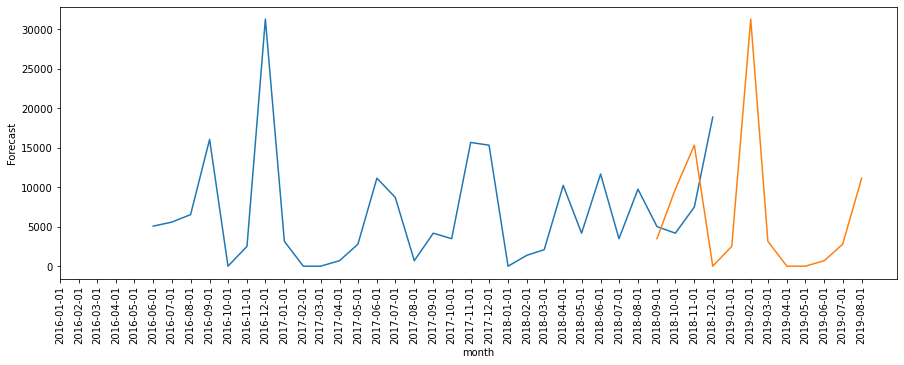

In [120]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.lineplot(x="month"
                  , y="actuals"
                  , markers=True
                  , dashes=False
                  , data=sb_data_ups[sb_data_ups["sub_brand"]=="AF233340MS"])

sns.lineplot(x="month"
                  , y="Forecast"
                  , markers=True
                  , dashes=False
                  , data=nov_forecast_df[nov_forecast_df["sub_brand"]=="AF233340MS"])
plt.xticks(nov_forecast_df["month"].unique(), rotation='vertical')
plt.show()